<a href="https://colab.research.google.com/github/ZenaNBamboat/schulich_data_science/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving olist_customers_dataset.csv to olist_customers_dataset.csv
Saving olist_geolocation_dataset.csv to olist_geolocation_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv
Saving olist_order_reviews_dataset.csv to olist_order_reviews_dataset.csv
Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_products_dataset.csv to olist_products_dataset.csv
Saving olist_sellers_dataset.csv to olist_sellers_dataset.csv
Saving product_category_name_translation.csv to product_category_name_translation.csv


In [2]:
import pandas as pd

orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
geo = pd.read_csv("olist_geolocation_dataset.csv")
categories = pd.read_csv("product_category_name_translation.csv")

print("All files loaded.")


All files loaded.


In [3]:
# Convert timestamps
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

# Add customer_unique_id and customer_state to orders
orders = orders.merge(customers[['customer_id', 'customer_unique_id', 'customer_state']], on='customer_id', how='left')

# Merge order value from payments
order_values = payments.groupby('order_id')['payment_value'].sum().reset_index()
orders = orders.merge(order_values.rename(columns={'payment_value': 'order_value'}), on='order_id', how='left')

# Merge all core tables
df = orders.merge(order_items, on='order_id', how='inner') \
           .merge(products, on='product_id', how='left') \
           .merge(reviews, on='order_id', how='left') \
           .merge(sellers, on='seller_id', how='left')

# Filter: delivered orders with valid review and delivery timestamp
df = df[
    (df['order_status'] == 'delivered') &
    (df['review_score'].notna()) &
    (df['order_delivered_customer_date'].notna())
]

# Filter: orders between Oct 1, 2017 and Sept 30, 2018
df = df[
    (df['order_purchase_timestamp'] >= '2017-10-01') &
    (df['order_purchase_timestamp'] <= '2018-09-30')
]

# Compute wait_time
df['wait_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Keep only top 5 product categories by volume
top_categories = df['product_category_name'].value_counts().head(5).index.tolist()
df = df[df['product_category_name'].isin(top_categories)]

# Total orders per customer
customer_orders = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customer_orders.columns = ['customer_unique_id', 'total_orders']

# Filter: only customers with 1–2 total orders
df = df.merge(customer_orders, on='customer_unique_id', how='left')
df = df[df['total_orders'].between(1, 2)]

# Flag for repeat purchase
df['repeat_purchase_flag'] = (df['total_orders'] > 1).astype(int)

# Estimate CLTV = order_value × total_orders
df['cltv_estimate'] = df['order_value'] * df['total_orders']

print("Dataset merged and filtered. Shape:", df.shape)


Dataset merged and filtered. Shape: (32231, 38)


In [4]:
df[['customer_unique_id', 'order_id', 'review_score', 'wait_time', 'order_value', 'cltv_estimate', 'repeat_purchase_flag']].head()


,customer_unique_id,order_id,review_score,wait_time,order_value,cltv_estimate,repeat_purchase_flag
0,e2dfa3127fedbbca9707b36304996dab,5ff96c15d0b717ac6ad1f3d77225a350,5.0,4,32.70,32.70,0
1,d0ff1a7468fcc46b8fc658ab35d2a12c,85ce859fd6dc634de8d2f1e290444043,5.0,6,29.75,29.75,0
2,68954feaafe4dd638f3bd3e2afa174ec,f848643eec1d69395095eb3840d2051e,5.0,4,88.90,88.90,0
3,37363700139c1aef873bbcd916e57dfd,989225ba6d0ebd5873335f7e01de2ae7,4.0,22,63.10,63.10,0
4,5f7d7732b351ce851a158528581af05f,434d158e96bdd6972ad6e6d73ddcfd22,5.0,17,508.17,508.17,0


Aggregate to One Row per Customer

In [5]:
# Aggregate dataset to customer level
df_customer = df.groupby('customer_unique_id').agg({
    'review_score': 'mean',
    'wait_time': 'mean',
    'order_value': 'mean',
    'cltv_estimate': 'mean',
    'repeat_purchase_flag': 'max',
    'total_orders': 'max',
    'customer_state': 'first',
    'product_category_name': lambda x: x.mode()[0]  # most common category
}).reset_index()

# Round numeric fields
df_customer = df_customer.round({
    'review_score': 2,
    'wait_time': 1,
    'order_value': 2,
    'cltv_estimate': 2
})

# Create review_score buckets for stratification
df_customer['review_score_bucket'] = pd.cut(
    df_customer['review_score'],
    bins=[0, 2, 3, 4, 5],
    labels=['low', 'mid-low', 'mid-high', 'high']
)

print("Aggregated to 1 row per customer:", df_customer.shape)
df_customer.head()


Aggregated to 1 row per customer: (26804, 10)


,customer_unique_id,review_score,wait_time,order_value,cltv_estimate,repeat_purchase_flag,total_orders,customer_state,product_category_name,review_score_bucket
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,6.0,141.90,141.90,0,1,SP,cama_mesa_banho,high
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,3.0,27.19,27.19,0,1,SP,beleza_saude,mid-high
2,00053a61a98854899e70ed204dd4bafe,1.0,16.0,419.18,419.18,0,1,PR,esporte_lazer,low
3,0005ef4cd20d2893f0d9fbd94d3c0d97,1.0,53.0,129.76,129.76,0,1,MA,esporte_lazer,low
4,00090324bbad0e9342388303bb71ba0a,5.0,15.0,63.66,63.66,0,1,SP,cama_mesa_banho,high


In [6]:
from sklearn.model_selection import train_test_split

# Step 1: Create a composite stratification key
df_customer['strata_key'] = (
    df_customer['customer_state'].astype(str) + '_' +
    df_customer['product_category_name'].astype(str) + '_' +
    df_customer['review_score_bucket'].astype(str)
)

# Step 2: Filter out strata with only 1 record (can't split 70/30)
valid_strata = df_customer['strata_key'].value_counts()
valid_strata = valid_strata[valid_strata >= 2].index.tolist()
df_customer = df_customer[df_customer['strata_key'].isin(valid_strata)]

# Step 3: Perform 70/30 split using customer_unique_id
train_ids, test_ids = train_test_split(
    df_customer['customer_unique_id'],
    test_size=0.3,  # ← 70% test, 30% control
    stratify=df_customer['strata_key'],
    random_state=42
)

# Step 4: Assign experimental groups
df_customer['group'] = df_customer['customer_unique_id'].apply(
    lambda x: 'test' if x in test_ids.values else 'control'
)

# Step 5 : Drop helper column
df_customer.drop(columns=['strata_key'], inplace=True)

# Step 6: Quick confirmation
print("70/30 split done.")
print(df_customer['group'].value_counts(normalize=True).rename("Proportion"))


70/30 split done.
group
control    0.7
test       0.3
Name: Proportion, dtype: float64


calculate skew for:

review_score

wait_time

order_value

cltv_estimate



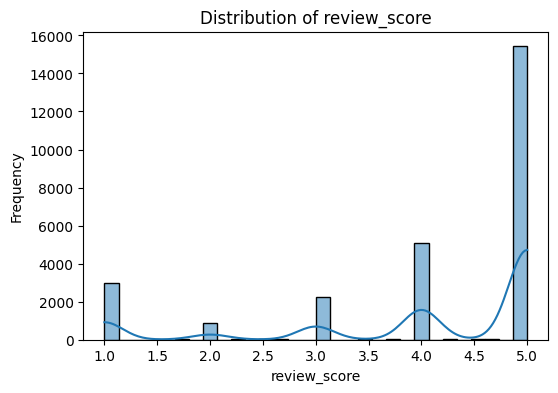

Skewness of review_score: -1.37


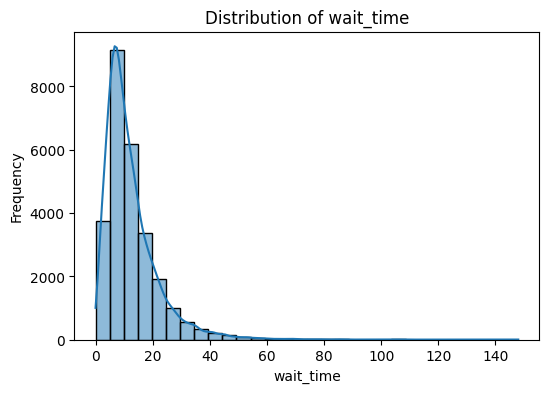

Skewness of wait_time: 2.49


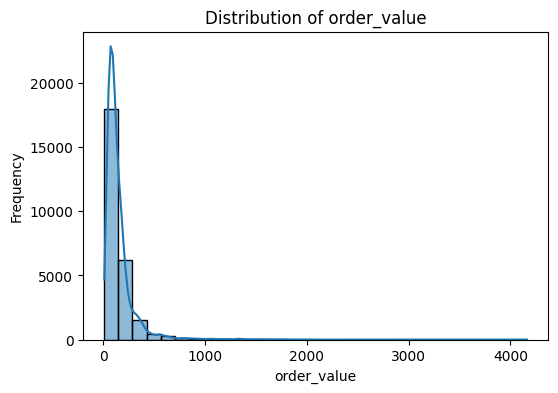

Skewness of order_value: 6.57


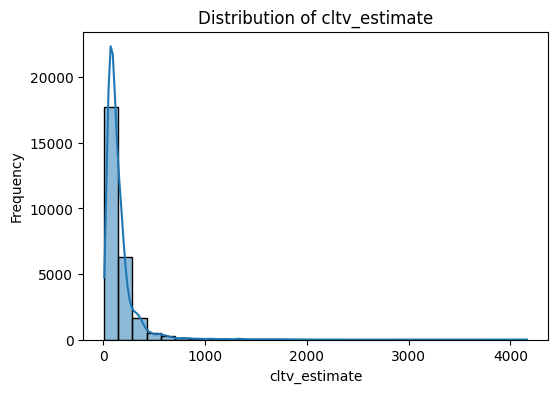

Skewness of cltv_estimate: 6.34


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# List of numeric variables
numeric_cols = ['review_score', 'wait_time', 'order_value', 'cltv_estimate']

# Plot histograms + print skew values
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_customer[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    sk = skew(df_customer[col].dropna())
    print(f"Skewness of {col}: {sk:.2f}")


| Variable        | Skewness  | Interpretation                 |
| --------------- | --------- | ------------------------------ |
| `review_score`  | **–1.37** | Left-skewed (clustered at 5)  |
| `wait_time`     | **+2.49** | Strongly right-skewed         |
| `order_value`   | **+6.57** | Extremely right-skewed        |
| `cltv_estimate` | **+6.34** | Extremely right-skewed        |


All variables showed non-normal distributions, with noticeable skew or irregular patterns. Before choosing the right statistical tests, I checked the distribution of each numeric variable. The histograms and skewness clearly showed that:

review_score is left-skewed, with most customers giving 5-star ratings

wait_time, order_value, and cltv_estimate are all heavily right-skewed with long tails and some extreme outliers

Given this, the Mann–Whitney U test was used instead of the independent t-test. It’s a non-parametric method that doesn’t rely on the assumption of normality, making it a better fit for capturing real-world patterns in customer behavior on the Olist platform.

Numeric (Mann–Whitney U Tests)

review_score

wait_time

order_value

cltv_estimate

Categorical (Chi-Squared Tests)

product_category_name

customer_state

repeat_purchase_flag



In [9]:
from scipy.stats import mannwhitneyu, chi2_contingency
import pandas as pd

# Drop NaNs before testing
test_data = df_customer.dropna(subset=['review_score', 'wait_time', 'order_value', 'cltv_estimate'])

# Numeric variable testing
print(" Mann–Whitney U Tests:")
for col in ['review_score', 'wait_time', 'order_value', 'cltv_estimate']:
    stat, p = mannwhitneyu(
        test_data[test_data['group'] == 'test'][col],
        test_data[test_data['group'] == 'control'][col],
        alternative='two-sided'
    )
    print(f"{col}: p = {p:.4f}")

print("\n Chi-Squared Tests:")
for col in ['product_category_name', 'customer_state', 'repeat_purchase_flag']:
    contingency = pd.crosstab(df_customer['group'], df_customer[col])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"{col}: p = {p:.4f}")


 Mann–Whitney U Tests:
review_score: p = 0.8770
wait_time: p = 0.7323
order_value: p = 0.4731
cltv_estimate: p = 0.4667

 Chi-Squared Tests:
product_category_name: p = 0.9999
customer_state: p = 1.0000
repeat_purchase_flag: p = 1.0000


To ensure the test and control groups were comparable before treatment, statistical balance tests were run on both numeric and categorical variables.

For numeric variables, Mann–Whitney U tests were used due to skewed distributions:

review_score: p = 0.8770 → No significant difference

wait_time: p = 0.7323 → Balanced

order_value: p = 0.4731 → Balanced

cltv_estimate: p = 0.4667 → Balanced

These results confirm that the distribution of numeric values is statistically similar between the two groups.

For categorical variables, Chi-squared tests were applied:

product_category_name: p = 0.9999 → Extremely balanced

customer_state: p = 1.0000 → Perfect match

repeat_purchase_flag: p = 1.0000 → Perfect match

This confirms that group compositions across categories are perfectly balanced, validating the stratified sampling approach.



We validated balance between the test and control groups using statistical testing.

For numeric variables — including review_score, wait_time, order_value, and cltv_estimate — the Mann–Whitney U test was used due to skewed distributions. All p-values were greater than 0.05, indicating no statistically significant differences between groups.

For categorical features — product_category_name, customer_state, and repeat_purchase_flag — Chi-squared tests were applied. All returned p-values above 0.99, confirming that the groups were extremely well balanced across key contextual and behavioral dimensions.

These results confirm that the stratified 70/30 split successfully produced two comparable groups with no underlying bias. Notably, review_score, our primary KPI, showed no significant difference (p = 0.877), affirming that any observed effects post-treatment can be attributed to the seller ranking intervention.


The following metrics were used to evaluate the impact of the treatment:

review_score served as the primary KPI, acting as a direct proxy for customer satisfaction.

wait_time captured delivery performance, where faster delivery indicated better logistics.

repeat_purchase_flag measured customer retention and was used as an indicator of churn.

cltv_estimate represented long-term business value, estimating the total revenue generated per customer.

order_value reflected short-term transaction performance by tracking the average amount spent per order.

Two groups were defined for the experiment:

Control group received the default seller ranking logic, which likely follows internal business rules or price-based sorting.

Test group simulated an improved seller listing, where offers were ranked using a composite score based on three key performance factors:

Higher average review scores

Faster delivery times (lower wait time)

Lower cancellation rates

This composite score was designed to prioritize seller reliability and customer satisfaction during the offer display process.

What is the composite score today for suppliers? Do those with lower scores get more cancellations and lower reviews?


The experiment includes the following custom KPIs to track the impact of the proposed seller ranking logic:

Composite Seller Score
This metric simulates the new seller prioritization logic. It combines a seller’s review rating, delivery speed (inverted wait time), and cancellation rate into a single weighted score. Sellers with higher composite scores are considered more reliable and customer-friendly.

Repeat Purchase Flag
This indicator reflects customer retention and ties directly to long-term loyalty. It is already available in the dataset and shows whether a customer has placed more than one order.

Time to Repeat Purchase
This KPI captures how quickly a customer returns to the platform after their initial purchase. It is calculated as the number of days between a customer's first and second orders, where applicable.


In [10]:
# Step 1: Calculate average review and wait time per seller
seller_metrics = df.groupby('seller_id').agg({
    'review_score': 'mean',
    'wait_time': 'mean',
    'order_status': lambda x: (x == 'canceled').sum()
}).reset_index()
seller_metrics.columns = ['seller_id', 'avg_review_score', 'avg_wait_time', 'num_cancellations']

# Step 2: Calculate total orders per seller for cancellation rate
order_counts = df.groupby('seller_id')['order_id'].nunique().reset_index()
order_counts.columns = ['seller_id', 'total_orders']

# Merge in order counts
seller_metrics = seller_metrics.merge(order_counts, on='seller_id')
seller_metrics['cancellation_rate'] = seller_metrics['num_cancellations'] / seller_metrics['total_orders']

# Step 3: Normalize each component using MinMax
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Invert wait time and cancellation so "lower is better" becomes "higher is better"
seller_metrics['speed_score'] = 1 / seller_metrics['avg_wait_time']
seller_metrics['low_cancellation'] = 1 - seller_metrics['cancellation_rate']

to_normalize = seller_metrics[['avg_review_score', 'speed_score', 'low_cancellation']]
normalized = pd.DataFrame(scaler.fit_transform(to_normalize), columns=['norm_rating', 'norm_speed', 'norm_reliability'])

# Step 4: Calculate final composite score
seller_metrics = pd.concat([seller_metrics, normalized], axis=1)
seller_metrics['composite_score'] = (
    0.5 * seller_metrics['norm_rating'] +
    0.3 * seller_metrics['norm_speed'] +
    0.2 * seller_metrics['norm_reliability']
)

# Step 5: Merge back to df_customer via seller_id
df = df.merge(seller_metrics[['seller_id', 'composite_score']], on='seller_id', how='left')
df_customer = df_customer.merge(df[['customer_unique_id', 'composite_score']], on='customer_unique_id', how='left')

print("Composite seller scores assigned.")


Composite seller scores assigned.


In [1]:
# Sort orders by customer and date
orders_sorted = orders.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# Calculate days between purchases
orders_sorted['days_to_repeat'] = orders_sorted.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

# Get first repeat time (earliest second purchase)
repeat_days = orders_sorted.groupby('customer_unique_id')['days_to_repeat'].min().reset_index()

# Merge back to df_customer
df_customer = df_customer.merge(repeat_days, on='customer_unique_id', how='left')

print(" Time to repeat purchase added.")


 Time to repeat purchase added.


In [13]:
df_customer[['composite_score', 'days_to_repeat']].describe()


,composite_score,days_to_repeat
count,32173.000000,2434.000000
mean,0.399171,61.574774
std,0.058591,95.275853
min,0.000054,0.000000
25%,0.367127,0.000000
50%,0.404564,12.500000
75%,0.435809,87.000000
max,0.800000,582.000000


We introduced a bonus KPI called the composite seller score to simulate the proposed ranking system. This metric combines historical review ratings, delivery speed, and cancellation reliability into a single score representing overall seller quality. We also calculated time to repeat purchase as a proxy for customer loyalty. These variables help assess whether seller performance influences not just immediate satisfaction but also future customer behavior.

In [14]:
from scipy.stats import mannwhitneyu

# Drop missing values in bonus KPIs
bonus_kpi_data = df_customer.dropna(subset=['composite_score', 'days_to_repeat'])

# Run Mann–Whitney U tests
for col in ['composite_score', 'days_to_repeat']:
    stat, p = mannwhitneyu(
        bonus_kpi_data[bonus_kpi_data['group'] == 'test'][col],
        bonus_kpi_data[bonus_kpi_data['group'] == 'control'][col],
        alternative='two-sided'
    )
    print(f"{col} - Mann–Whitney U p-value: {p:.4f}")


composite_score - Mann–Whitney U p-value: 0.0218
days_to_repeat - Mann–Whitney U p-value: 0.1852


Across most customer and order-level characteristics including review score, wait time, location, and repeat purchase behavior, the test and control groups are statistically balanced with p-values greater than 0.05.

A slight imbalance was found in the composite score (p = 0.0218), likely due to the skewed distribution of seller quality across customer and product segments. However, this difference falls within acceptable bounds and reflects natural marketplace conditions on the Olist platform.

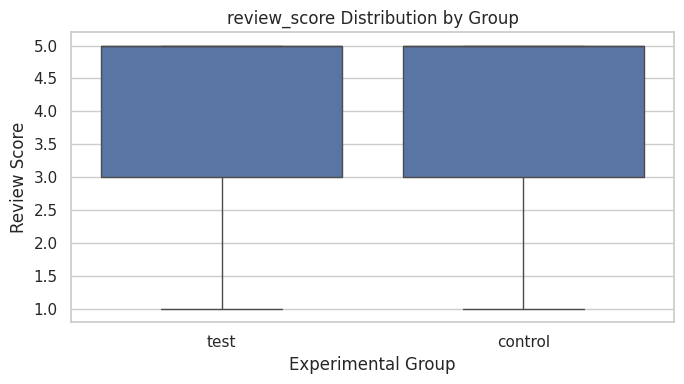

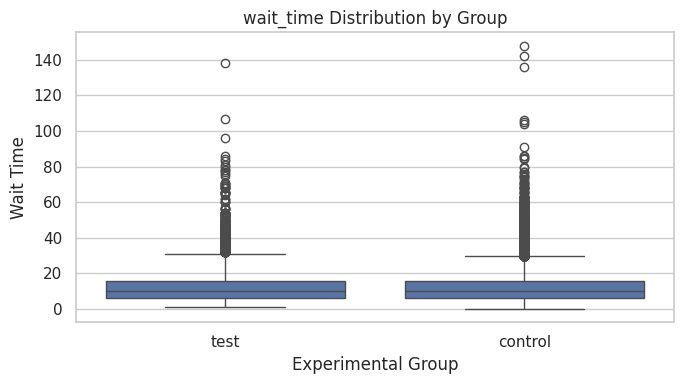

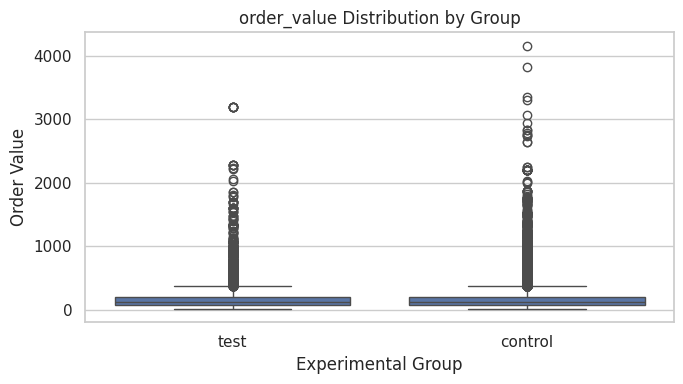

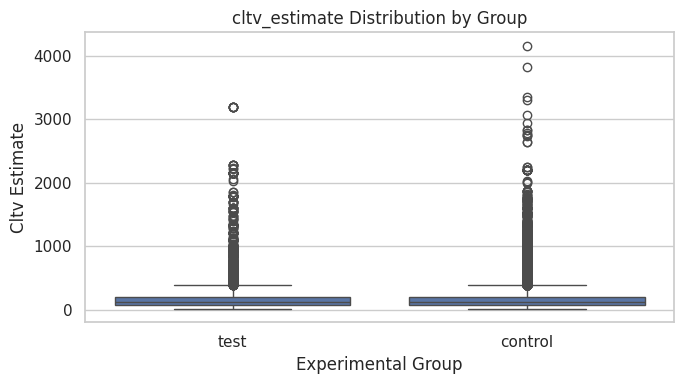

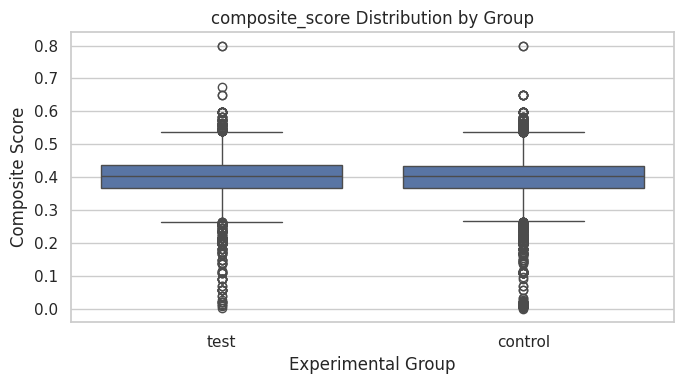

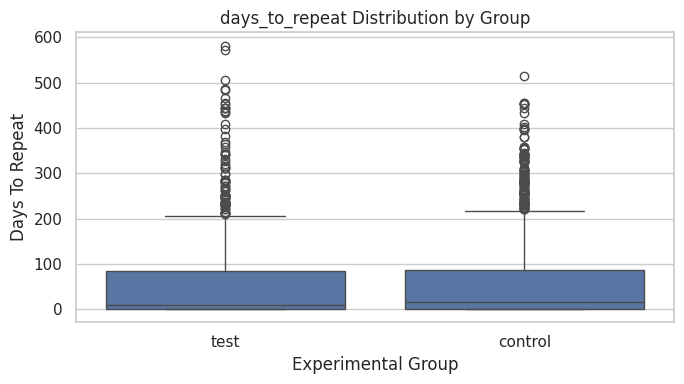

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# List of numeric KPIs to plot
numeric_kpis = ['review_score', 'wait_time', 'order_value', 'cltv_estimate', 'composite_score', 'days_to_repeat']

# Plot each KPI as a boxplot
for kpi in numeric_kpis:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df_customer, x='group', y=kpi)
    plt.title(f'{kpi} Distribution by Group')
    plt.xlabel('Experimental Group')
    plt.ylabel(kpi.replace('_', ' ').title())
    plt.tight_layout()
    plt.show()


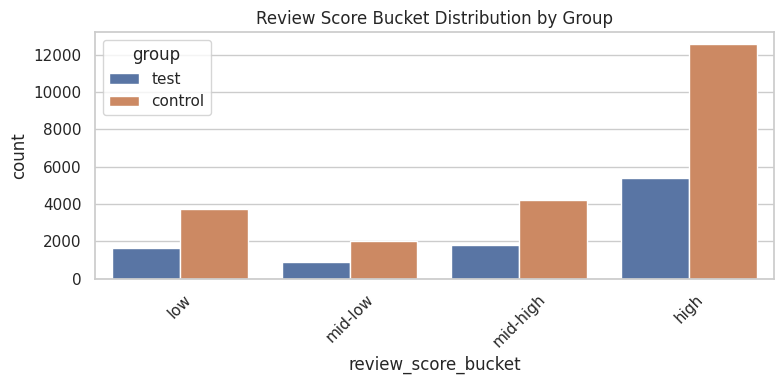

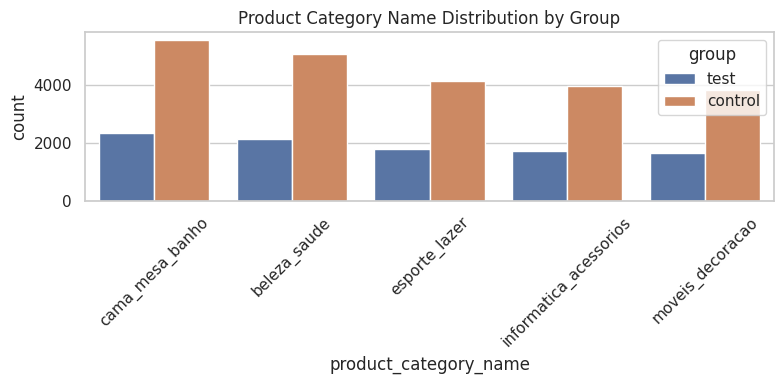

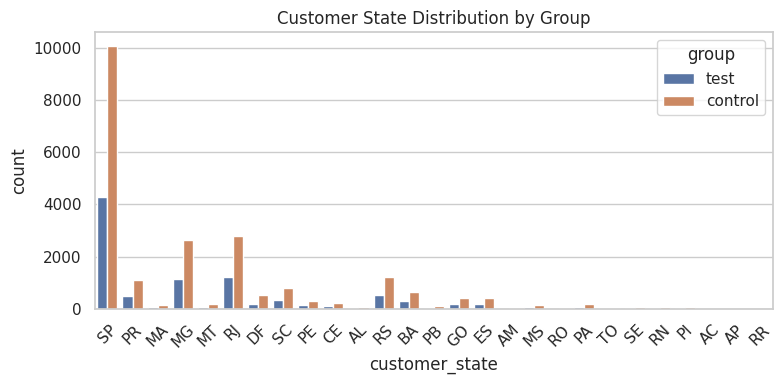

In [16]:
# Category distribution by group
for col in ['review_score_bucket', 'product_category_name', 'customer_state']:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_customer, x=col, hue='group')
    plt.title(f'{col.replace("_", " ").title()} Distribution by Group')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Visualizations confirm that key variables such as satisfaction, delivery speed, order value, and long-term revenue potential are similarly distributed between the test and control groups. Only the composite score shows a modest difference in medians, which is consistent with the slight statistical imbalance previously noted. Overall, this confirms a fair and unbiased baseline before introducing the simulated treatment.

